#https://www.kaggle.com/datasets/pranavraikokte/covid19-image-dataset

# Assignment - COVID XRAY

## Objective
A healthcare startup aims to accelerate and improve COVID-19 diagnosis using deep learning technologies. The current testing procedures are time-consuming and rely heavily on manual radiological examination, which limits scalability in pandemic situations.
As a data scientist, your task is to build a Convolutional Neural Network (CNN) model that can automatically detect COVID-19 from chest X-ray images. This solution can help hospitals:
- Reduce diagnosis time.
- Minimize burden on radiologists.
- Scale testing across regions with limited radiological expertise.
This project allows you to apply deep learning concepts, understand how CNNs process image data, and build real-world applications that can assist the medical community.


# For Google Colab Execution

In [83]:
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

In [84]:
#!kaggle datasets download -d pranavraikokte/covid19-image-dataset

In [85]:
#import zipfile
#zip_ref = zipfile.ZipFile('/content/dogs-vs-cats.zip', 'r')
#zip_ref.extractall('/content')
#zip_ref.close()

# For Local Data Execution

In [143]:
#%pip install opencv-python

import os
import shutil
import random
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model #for model visualization

In [144]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras_tuner import HyperModel #for hyperparameter tuning
from keras_tuner.tuners import RandomSearch #for hyperparameter tuning
from keras.callbacks import EarlyStopping #for early stopping during training   
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout

# Data Explanation

Each image is labelled into one of the following classes:
- COVID-19 – Confirmed COVID infection.
- Viral Pneumonia – Non-COVID lung infection.
- Normal – No visible lung abnormality.


# Data Details

In [145]:
import glob
train = glob.glob('Covid19-dataset/train/*/*')
test = glob.glob('Covid19-dataset/test/*/*')
print('Train:', len(train))
print('Test:', len(test))
print('Total Data:', len(train) + len(test))
print('Train:', train[:5])
print('Test:', test[:5])

Train: 5395
Test: 1354
Total Data: 6749
Train: ['Covid19-dataset/train\\Covid\\01.jpeg', 'Covid19-dataset/train\\Covid\\010.png', 'Covid19-dataset/train\\Covid\\012.jpeg', 'Covid19-dataset/train\\Covid\\015.jpg', 'Covid19-dataset/train\\Covid\\019.png']
Test: ['Covid19-dataset/test\\Covid\\0100.jpeg', 'Covid19-dataset/test\\Covid\\0102.jpeg', 'Covid19-dataset/test\\Covid\\0105.png', 'Covid19-dataset/test\\Covid\\0106.jpeg', 'Covid19-dataset/test\\Covid\\0108.jpeg']


# Split Data for Train and Test

In [146]:
def split(path): 

    source_folder = path
    train_folder = 'train'
    val_folder = 'validation'
    path.split('/')
    if len(path.split('/')) > 1:
        train_folder = os.path.join(train_folder, path.split('/')[-1])
        val_folder = os.path.join(val_folder, path.split('/')[-1])
        print(f"Splitting data from {source_folder} into {train_folder} and {val_folder}")
    else:
        print(f"Splitting data from {source_folder} into 'train/' and 'validation/'")   

    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(val_folder, exist_ok=True)

    all_images = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]

    random.shuffle(all_images)

    split_index = int(0.8 * len(all_images))

    train_images = all_images[:split_index]
    val_images = all_images[split_index:]

    for img in train_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(train_folder, img))

    for img in val_images:
        shutil.copy(os.path.join(source_folder, img), os.path.join(val_folder, img))

    print(f"Split complete: {len(train_images)} images in 'train/', {len(val_images)} images in 'validation/'")

#split("facemask/with_mask")
#split("facemask/without_mask")

# Image Generator
**Definition**
- ImageDataGenerator is used to create generators that load and transform image data on the fly. 
- It reads images from a directory or array, applies preprocessing and augmentation, and yields batches for training.


| Parameter                   | Sample Value        | Description                                                                 |
|----------------------------|---------------------|-----------------------------------------------------------------------------|
| `rescale`                  | `1./255`            | Normalizes pixel values to [0, 1] range.                                    |
| `rotation_range`           | `30`                | Randomly rotates images by up to 30 degrees.                               |
| `width_shift_range`        | `0.2`               | Shifts images horizontally by 20% of width.                                |
| `height_shift_range`       | `0.2`               | Shifts images vertically by 20% of height.                                 |
| `shear_range`              | `0.2`               | Applies shear transformation with intensity 0.2.                           |
| `zoom_range`               | `0.2`               | Randomly zooms images by up to 20%.                                        |
| `horizontal_flip`          | `True`              | Randomly flips images horizontally.                                        |
| `vertical_flip`            | `False`             | Randomly flips images vertically.                                          |
| `brightness_range`         | `(0.5, 1.5)`         | Adjusts brightness randomly within this range.                             |
| `channel_shift_range`      | `50.0`              | Randomly shifts color channels by intensity.                               |
| `fill_mode`                | `'nearest'`         | Strategy for filling in pixels after transformations.                      |
| `cval`                     | `0.0`               | Value used when `fill_mode='constant'`.                                    |
| `preprocessing_function`   | `custom_fn`         | Custom function applied to each image after augmentation.                  |
| `validation_split`         | `0.2`               | Reserves 20% of data for validation.                                       |
| `featurewise_center`       | `False`             | Subtracts mean of dataset from each image.                                 |
| `samplewise_center`        | `False`             | Subtracts mean of each image individually.                                 |
| `featurewise_std_normalization` | `False`       | Divides images by dataset-wide std deviation.                             |
| `samplewise_std_normalization`  | `False`       | Divides each image by its own std deviation.                              |
| `zca_whitening`            | `False`             | Applies ZCA whitening (decorrelation).                                     |

In [174]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#train_generator.reset()
#
# validation_generator.reset()

batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,              # Normalize pixel values
        rotation_range=30,           # Random rotation
        width_shift_range=0.1,       # Horizontal shift
        height_shift_range=0.1,      # Vertical shift
        shear_range=0.2,             # Shear transformation
        zoom_range=0.2,              # Zoom
        horizontal_flip=True,        # Flip horizontally
        fill_mode='nearest'          # Fill strategy for empty pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'Covid19-dataset/train',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='sparse'
        )  # Use 'sparse' for integer labels, 'categorical' for one-hot encoded labels

# If you have multiple classes, use 'categorical' or 'sparse' based on your label format

validation_generator = test_datagen.flow_from_directory(
        'Covid19-dataset/test',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='sparse'
        )  # Use 'sparse' for integer labels, 'categorical' for one-hot encoded labels



# Make sure labels are 1D integer numpy arrays
train_generator.classes = np.array(train_generator.classes, dtype=np.int32)
validation_generator.classes = np.array(validation_generator.classes, dtype=np.int32)

Found 5395 images belonging to 3 classes.
Found 1354 images belonging to 3 classes.


# Load DataSet for TensorFlow

#### The function keras.utils.image_dataset_from_directory()
- Is a high-level utility in TensorFlow/Keras that helps you load image data from a directory structure.
-  into a tf.data.Dataset object, which is ideal for training deep learning models.
  
  **Key Parameters**
| Parameter          | Description                                                                 |
|--------------------|-----------------------------------------------------------------------------|
| `directory`         | Path to the root folder containing subfolders of images.                   |
| `labels`            | `'inferred'`, `None`, or a list of labels. `'inferred'` uses subfolder names. |
| `label_mode`        | `'int'`, `'categorical'`, `'binary'`, or `None`. Determines label format.  |
| `batch_size`        | Number of images per batch. Default is 32.                                 |
| `image_size`        | Tuple `(height, width)` to resize images.                                  |
| `shuffle`           | Whether to shuffle the data. Default is `True`.                            |
| `validation_split`  | Float between 0 and 1 to split data for validation.                        |
| `subset`            | `'training'` or `'validation'` if using `validation_split`.                |
| `seed`              | Random seed for reproducibility.                                           |

#### **Parameter	Description**
- **` directory `**	Path to the main folder containing subfolders of images. Each subfolder is treated as a separate class.
- **` labels='inferred' `**	Automatically infers labels based on subfolder names (e.g., Covid, Normal, Viral Pneumonia).
- **` label_mode='int' `**	Labels are returned as integers (0, 1, 2, etc.). Alternatives: 'categorical', 'binary', 'none'.
- **` batch_size=32 `**	Number of images to load in each batch.
- **` image_size=(256, 256) `**	Resizes all images to 256×256 pixels. Useful for consistency in input shape to CNNs.

In [175]:
# generators
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'Covid19-dataset/train',
    labels='inferred',                                              # Fpr inferred labels
    label_mode = 'int',                                             # 'int' for integer labels for sparse, 'categorical' for one-hot encoded labels for categorical crossentropy
    #label_mode = 'categorical',                                    # Uncomment this line if you want to use categorical labels
    #label_mode = None,                                             # Uncomment this line if you want to use no labels
    #label_mode = 'binary',                                         # Uncomment this line if you want to use binary labels
    #label_mode = 'multi_hot',                                      # Uncomment this line if you want to use multi-hot encoded labels
    #label_mode = 'raw',                                            # Uncomment this line if you want to use raw labels
    #label_mode = 'sparse',                                         # Uncomment this line if you want to use sparse labels
    #label_mode = 'multi_class',                                    # Uncomment this line if you want to use multi-class labels
    #label_mode = 'multi_label',                                    # Uncomment this line if you want to use multi-label labels
    #label_mode = 'categorical_crossentropy',                       # Uncomment this line if you want to use categorical crossentropy labels
    #label_mode = 'sparse_categorical_crossentropy',                # Uncomment this line if you want to use sparse categorical crossentropy labels
    #label_mode = 'binary_crossentropy',                             # Uncomment this line if you want to use binary crossentropy labels
    #label_mode = 'multi_label_categorical_crossentropy',           # Uncomment this line if you want to use multi-label categorical crossentropy labels
    #label_mode = 'multi_label_sparse_categorical_crossentropy',    # Uncomment this line if you want to use multi-label sparse categorical crossentropy labels
    #label_mode = 'multi_label_binary_crossentropy',                 # Uncomment this line if you want to use multi-label binary crossentropy labels           
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'Covid19-dataset/test',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 5395 files belonging to 3 classes.
Found 1354 files belonging to 3 classes.


## **Normalization** : Normalizing image pixel values and applying the transformation to both the training and validation datasets.
✅ **Function process**
- **` image / 255.: `** Pixel values in images typically range from 0 to 255. This line scales them to a range of [0, 1], which helps neural networks converge faster during training.
- **` tf.cast(..., tf.float32): `** Ensures the image tensor is of type float32 (required by TensorFlow models).
- Returns a tuple (normalized_image, label).

🧠 **Why normalization?**
- Prevents large input values from dominating gradient updates.
- Helps the model learn faster and generalize better.
- Essential for stable training of deep networks.

In [177]:
# Normalize or standardize().
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

# NOTE : 
#### When using ImageDataGenerator with rescale=1./255, you're already normalizing the pixel values to the [0, 1] range. So there's no need for additional normalization afterward.

**Here’s a quick breakdown**:

**What rescale=1./255 Does:** 
- Converts pixel values from [0, 255] to [0.0, 1.0]
- This is sufficient for most CNN models using ReLU activations and standard architectures

- When You Might Normalize Again
- You’d only need further normalization if:
- You're using a pretrained model like VGG, ResNet, etc., that expects specific preprocessing (e.g., mean subtraction)
- You're switching to image_dataset_from_directory, which loads raw pixel values unless you manually normalize

# How to build CNN Architecture

---

### **Sequential API**:

```python
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='valid', activation='relu', input_shape=(256,256,3)))
```

###  **Functional API**:

```python
input_layer = Input(shape=(256, 256, 3))
x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
model = Model(inputs=input_layer, outputs=x)
```

---

##  Comparison

| Feature / Aspect         | **Sequential API**                          | **Functional API**                                     |
| ------------------------ | ------------------------------------------- | ------------------------------------------------------ |
| 🔧 **Usage**             | Quick and easy for simple stack of layers   | Used for more complex, non-linear architectures        |
| 📤 **Input Layer**       | Defined inside `Conv2D` via `input_shape`   | Defined explicitly using `Input(...)`                  |
| 🧠 **Flexibility**       | Limited — one input/output, linear model    | High — multiple inputs/outputs, skip connections, etc. |
| 🔁 **Layer Reusability** | Hard to reuse layers                        | Easy — layers are just functions on tensors            |
| 🔌 **Custom models**     | Not suitable for branching or shared layers | Perfect for residuals, attention, multi-modal inputs   |
| ✅ **Best for**           | Quick prototypes, beginner-level models     | Production models, research, complex architectures     |


##  When to Use What?

### Use **Sequential API**:

* If your model is a simple **stack of layers** from input to output.
* For **fast prototyping**.

### Use **Functional API**:

* If you need **more control** over how layers are connected.
* For models with:

  * **Multiple inputs or outputs**
  * **Skip connections (e.g., ResNet)**
  * **Shared layers (e.g., Siamese networks)**


###  Output Shape Equivalence?

Yes — in both examples, if input shape is `(256, 256, 3)`, output shape from the Conv2D layer will be:

```
(254, 254, 32) → due to valid padding and kernel size (3x3)
```

###  Summary

\| Want simplicity? | → Use `Sequential()` + `.add(...)` |
\| Need flexibility? | → Use `Input(...)` + `Model(...)` |

In [178]:
# create CNN model
# CNN Architecture ()
from tensorflow.keras.layers import Input, Conv2D, Normalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model

# Simple CNN Model
# This is a simple CNN model for image classification.
# It consists of several convolutional layers followed by max pooling and dense layers.
# The model is designed to classify images into two classes: Covid and Normal.

from tensorflow.keras import backend as K
K.clear_session()

#Layer1
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(256,256,3)))

# Complete the model architecture
# The model consists of several convolutional layers followed by max pooling and dense layers.
# Each convolutional layer is followed by batch normalization to stabilize the learning process.
# The final output layer uses a sigmoid activation function for binary classification.  

#input_layer = Input(shape=(256, 256, 3))
#x = Conv2D(32, kernel_size=(3, 3), padding='valid', activation='relu')(input_layer)
#model = Model(inputs=input_layer, outputs=x)

model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
print("Layer1",model.input_shape)
#Layer2
model.add(Conv2D(64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
print("Layer2",model.input_shape)

#Layer3
model.add(Conv2D(128,kernel_size=(3,3),padding='same',activation='relu')) # he_normal is a good choice for ReLU activations
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='same'))
print("Layer3",model.input_shape)

model.add(Flatten())
print("Flatten",model.input_shape)

# ANN Architecture
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3,activation='softmax')) # Use 'sigmoid' for binary classification
print("Final",model.input_shape)

c:\DataScience\tensor_python310\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Layer1 (None, 256, 256, 3)
Layer2 (None, 256, 256, 3)
Layer3 (None, 256, 256, 3)
Flatten (None, 256, 256, 3)
Final (None, 256, 256, 3)


In [179]:
model.input_shape

(None, 256, 256, 3)

In [180]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    33,554,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,690,179 (128.52 MB)

 Trainable params: 33,689,731 (128.52 MB)

 Non-trainable params: 448 (1.75 KB)

### 🧩 `tf.keras.callbacks.ReduceLROnPlateau` Parameters

```python
tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=1e-4,
    cooldown=0,
    min_lr=0,
)
```

---

### 📘 Parameter Details

| Parameter | Description |
|----------|-------------|
| **`monitor`** | Metric to monitor (e.g., `'val_loss'`, `'val_accuracy'`). |
| **`factor`** | Factor by which the learning rate will be reduced. `new_lr = lr * factor`. |
| **`patience`** | Number of epochs with no improvement after which learning rate will be reduced. |
| **`verbose`** | Verbosity mode: `0` = silent, `1` = messages when reducing LR. |
| **`mode`** | `'auto'`, `'min'`, or `'max'`. Determines whether to look for decreasing or increasing metric values. |
| **`min_delta`** | Threshold for measuring the new optimum, to only reduce LR if the improvement is significant. |
| **`cooldown`** | Number of epochs to wait after LR has been reduced before resuming normal operation. |
| **`min_lr`** | Lower bound on the learning rate. |

---



In [181]:

# Reduce learning rate if validation loss plateaus
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=50,
    min_lr=1e-4,
    verbose=1,
)

### 🧩 `tf.keras.callbacks.EarlyStopping` Parameters

```python
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=0,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)
```

---

### 📘 Parameter Details

| Parameter | Description |
|----------|-------------|
| **`monitor`** | Metric to monitor (e.g., `'val_loss'`, `'val_accuracy'`). |
| **`min_delta`** | Minimum change in the monitored metric to qualify as an improvement. |
| **`patience`** | Number of epochs with no improvement after which training will be stopped. |
| **`verbose`** | Verbosity mode: `0` = silent, `1` = messages when stopping. |
| **`mode`** | `'auto'`, `'min'`, or `'max'`. Decides whether to look for increasing or decreasing metric values. |
| **`baseline`** | Baseline value for the monitored metric. Training will stop if the model doesn't improve beyond this baseline. |
| **`restore_best_weights`** | If `True`, restores model weights from the epoch with the best value of the monitored metric. |
| **`start_from_epoch`** | Epoch from which to start monitoring the metric. Useful for skipping early fluctuations. |

---

In [182]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

### 🧩 `tf.keras.callbacks.ModelCheckpoint` Parameters

```python
tf.keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    initial_value_threshold=None
)
```

---

### 📘 Parameter Details

| Parameter | Description |
|----------|-------------|
| **`filepath`** | String, path to save the model file. Can include formatting options like `{epoch:02d}-{val_loss:.2f}`. |
| **`monitor`** | Quantity to monitor (e.g., `'val_loss'`, `'val_accuracy'`). |
| **`verbose`** | Verbosity mode: `0` = silent, `1` = messages when saving. |
| **`save_best_only`** | If `True`, saves only when the monitored metric improves. |
| **`save_weights_only`** | If `True`, only the model’s weights are saved (not the full model). |
| **`mode`** | One of `'auto'`, `'min'`, `'max'`. Decides whether to look for increasing or decreasing metric values. |
| **`save_freq`** | `'epoch'` or integer. If integer, saves every `save_freq` batches. |
| **`options`** | Optional `tf.saved_model.SaveOptions` for saving. |
| **`initial_value_threshold`** | Minimum value of the monitored metric to start saving checkpoints. |

---

In [183]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',           # where to save the model
    monitor='val_loss',                 # metric to monitor
    save_best_only=True,               # only save when val_loss improves
    save_weights_only=False,           # set True to save weights only
    mode='min',                        # 'min' for val_loss, 'max' for accuracy
    verbose=1                          # logs when model is saved
)


### 🧩 `model.compile()` Parameters

```python
model.compile(
    optimizer=None,
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    jit_compile=None,
    **kwargs
)
```

---

### 📘 Parameter Details

| Parameter             | Description |
|----------------------|-------------|
| **`optimizer`**       | String name (e.g., `'adam'`) or optimizer instance (e.g., `tf.keras.optimizers.Adam()`). Controls how the model updates weights. |
| **`loss`**            | String name (e.g., `'mse'`, `'categorical_crossentropy'`) or a loss function. Defines what the model tries to minimize. |
| **`metrics`**         | List of metrics to evaluate during training and testing (e.g., `['accuracy']`). |
| **`loss_weights`**    | Optional list or dict specifying scalar coefficients to weight the loss contributions of different model outputs. |
| **`weighted_metrics`**| List of metrics to be evaluated and weighted by `sample_weight` or `class_weight` during training. |
| **`run_eagerly`**     | Boolean. If `True`, runs the model eagerly instead of using `tf.function`. Useful for debugging. |
| **`steps_per_execution`** | Integer. Number of batches to run during each `tf.function` call. Improves performance. |
| **`jit_compile`**     | Boolean. If `True`, compiles the model with XLA (Accelerated Linear Algebra) for potential performance gains. |
| **`**kwargs`**        | Additional keyword arguments for custom training logic or extensions. |

---

**Summary**
**Metric	Description**
- accuracy :	Binary accuracy when used with binary_crossentropy
- Precision() :	How precise your positive predictions are
- Recall() :	How many actual positives were captured
- AUC() :	How well the model separates the two classes

In [184]:
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Metric

class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = keras.metrics.Precision()
        self.recall = keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [185]:
from tensorflow.keras.metrics import Metric
import tensorflow as tf

class SparseF1Score(Metric):
    def __init__(self, name='sparse_f1_score', num_classes=3, **kwargs):
        super(SparseF1Score, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.true_positives = self.add_weight(name='tp', shape=(num_classes,), initializer='zeros')
        self.false_positives = self.add_weight(name='fp', shape=(num_classes,), initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', shape=(num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # y_true shape: (batch_size,) — integer labels
        # y_pred shape: (batch_size, num_classes) — logits or probabilities
        y_pred_labels = tf.argmax(y_pred, axis=1)

        for i in range(self.num_classes):
            y_true_i = tf.equal(y_true, i)
            y_pred_i = tf.equal(y_pred_labels, i)

            tp = tf.reduce_sum(tf.cast(tf.logical_and(y_true_i, y_pred_i), self.dtype))
            fp = tf.reduce_sum(tf.cast(tf.logical_and(tf.logical_not(y_true_i), y_pred_i), self.dtype))
            fn = tf.reduce_sum(tf.cast(tf.logical_and(y_true_i, tf.logical_not(y_pred_i)), self.dtype))

            self.true_positives[i].assign_add(tp)
            self.false_positives[i].assign_add(fp)
            self.false_negatives[i].assign_add(fn)

    def result(self):
        precision = self.true_positives / (self.true_positives + self.false_positives + tf.keras.backend.epsilon())
        recall = self.true_positives / (self.true_positives + self.false_negatives + tf.keras.backend.epsilon())
        f1 = 2 * precision * recall / (precision + recall + tf.keras.backend.epsilon())
        return tf.reduce_mean(f1)

    def reset_states(self):
        for var in self.variables:
            var.assign(tf.zeros_like(var))


In [186]:
metrics_category = [
    'accuracy',
    keras.metrics.Precision(),
    keras.metrics.Recall(),
    keras.metrics.AUC(),
    F1Score()
]

In [187]:
metrics_sparse = [
    'accuracy',
    keras.metrics.SparseCategoricalAccuracy(),
    keras.metrics.SparseCategoricalCrossentropy(),
    keras.metrics.AUC()
]

###  **Optimizers**
- **`GD – Stochastic Gradient Descent`**
- **`Adam – Adaptive Moment Estimation`**
- **`RMSprop – Root Mean Square Propagation`**
- **`Adagrad – Adaptive Gradient Algorithm`**
- **`Adadelta – An extension of Adagrad`**
- **`Adamax – Variant of Adam based on infinity norm`**
- **`Nadam – Adam with Nesterov momentum`**
- **`Ftrl – Follow The Regularized Leader (less common)`**

###  **Loss Functions**

#### 🔹 For Classification:
- **`binary_crossentropy`** – For binary classification (2 classes)
- **`categorical_crossentropy`** – For multi-class classification with one-hot encoded labels
- **`sparse_categorical_crossentropy`** – For multi-class classification with integer labels

#### 🔹 For Regression:
- **`mean_squared_error` (MSE)** – Penalizes larger errors more
- **`mean_absolute_error` (MAE)** – Measures average magnitude of errors
- **`huber_loss`** – Combines MSE and MAE, robust to outliers

#### 🔹 For Custom Tasks:
- **`kullback_leibler_divergence`** – Measures how one probability distribution diverges from another
- **`cosine_similarity`** – Measures similarity between predicted and true vectors

---

###  **Metrics**

#### 🔹 For Classification:
- **`accuracy`** – Overall accuracy
- **`binary_accuracy`** – For binary classification
- **`categorical_accuracy`** – For multi-class classification
- **`precision`**, **`recall`**, **`AUC`** – For more detailed performance analysis

#### 🔹 For Regression:
- **`mean_squared_error`**
- **`mean_absolute_error`**
- **`mean_absolute_percentage_error`**
- **`RootMeanSquaredError`**

# Model Compile

In [188]:
model.compile(optimizer=Adam(learning_rate=1e-4),loss='sparse_categorical_crossentropy',metrics=metrics_sparse)

### 🧩 `model.fit()` Parameters

```python
model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False
)
```

---

### 📘 Parameter Details

| Parameter | Description |
|----------|-------------|
| **`x`** | Input data. Can be a NumPy array, TensorFlow tensor, or a dataset. |
| **`y`** | Target data (labels). |
| **`batch_size`** | Number of samples per gradient update. |
| **`epochs`** | Number of times the model is trained on the entire dataset. |
| **`verbose`** | Verbosity mode: `0` = silent, `1` = progress bar, `2` = one line per epoch. |
| **`callbacks`** | List of Keras callbacks (e.g., `EarlyStopping`, `ModelCheckpoint`). |
| **`validation_split`** | Fraction of training data to be used as validation data. |
| **`validation_data`** | Data on which to evaluate the loss and metrics at the end of each epoch. |
| **`shuffle`** | Whether to shuffle the training data before each epoch. |
| **`class_weight`** | Optional dictionary mapping class indices to weights. |
| **`sample_weight`** | Optional array of weights for each sample. |
| **`initial_epoch`** | Epoch at which to start training (useful for resuming training). |
| **`steps_per_epoch`** | Total number of steps (batches of samples) before declaring one epoch finished. |
| **`validation_steps`** | Number of steps to run validation for each epoch. |
| **`validation_batch_size`** | Batch size used for validation. |
| **`validation_freq`** | Frequency (in epochs) at which to evaluate the validation data. |
| **`max_queue_size`** | Maximum size for the generator queue. |
| **`workers`** | Number of worker threads for data loading. |
| **`use_multiprocessing`** | Whether to use multiprocessing for data loading. |

---

In [189]:
print(train_generator.class_mode)
print(validation_generator.class_mode)

sparse
sparse


In [191]:
print(train_generator.class_indices)
print(train_generator.class_indices)

{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}
{'Covid': 0, 'Normal': 1, 'Viral Pneumonia': 2}


# Class Weight Balancing - Imbalance issue

In [192]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

class AutoClassWeight(Callback):
    def __init__(self, train_generator):
        super().__init__()
        self.train_generator = train_generator

    def on_epoch_begin(self, epoch, logs=None):
        # Extract labels from generator
        labels = self.train_generator.classes
        classes = np.unique(labels)

        # Compute new weights
        weights = compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=labels
        )
        weights_dict = {int(k): float(v) for k, v in enumerate(weights)}

        # Save to model attribute for tracking
        self.model.current_class_weights = weights_dict

        print(f"\n[Epoch {epoch+1}] Auto-updated class weights: {weights_dict}")

    def on_train_batch_begin(self, batch, logs=None):
        # Nothing special needed here unless you want per-batch weights
        pass

    def on_train_batch_end(self, batch, logs=None):
        pass

auto_weight_cb = AutoClassWeight(train_generator)

In [194]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_generator.classes
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = {i: float(w) for i, w in enumerate(class_weights_array)}
print("Class Weights:", class_weights)



Class Weights: {0: 3.1494454173963806, 1: 1.346057884231537, 2: 0.5155772171253823}


# Class Distribution

In [195]:
import os
from collections import Counter

train_dir = 'Covid19-dataset/train'
val_dir = 'Covid19-dataset/test'

def get_class_distribution(directory):
    classes = []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            count = len(os.listdir(class_path))
            classes.append((class_name, count))
    return classes

print("Train class distribution:")
print(get_class_distribution(train_dir))

print("\nValidation class distribution:")
print(get_class_distribution(val_dir))

Train class distribution:
[('Covid', 571), ('Normal', 1336), ('Viral Pneumonia', 3488)]

Validation class distribution:
[('Covid', 142), ('Normal', 337), ('Viral Pneumonia', 875)]


In [196]:
x_batch, y_batch = next(train_generator)
print("Label batch shape:", y_batch.shape)
print("Label batch dtype:", y_batch.dtype)
print("Unique labels:", np.unique(y_batch))

x_batch, y_batch = next(validation_generator)
print("Label batch shape:", y_batch.shape)
print("Label batch dtype:", y_batch.dtype)
print("Unique labels:", np.unique(y_batch))


Label batch shape: (32,)
Label batch dtype: float32
Unique labels: [0. 1. 2.]
Label batch shape: (32,)
Label batch dtype: float32
Unique labels: [0. 1. 2.]


# Label Validation

In [197]:
images, labels = next(train_generator)
print("Image batch shape:", images.shape)  # e.g. (32, 150, 150, 3)
print("Label batch shape:", labels.shape)  # e.g. (32,)
print("Label example:", labels)   

images, labels = next(validation_generator)
print("Image batch shape:", images.shape)  # e.g. (32, 150, 150, 3)
print("Label batch shape:", labels.shape)  # e.g. (32,)
print("Label example:", labels)  # e.g. [0. 2. 1. 0. 2.]


Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Label example: [1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 2. 1. 2. 2. 0. 2. 2. 2. 1. 1.
 2. 1. 2. 2. 2. 1. 2. 2.]
Image batch shape: (32, 256, 256, 3)
Label batch shape: (32,)
Label example: [2. 2. 2. 2. 0. 2. 2. 2. 1. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 1. 2. 2. 2. 2. 1. 2. 2.]


In [198]:
print("Output layer units:", model.layers[-1].units)  # should be 3
print("Loss:", model.loss)  # should be 'sparse_categorical_crossentropy'
print("class_mode in generator:", train_generator.class_mode)  # should be 'sparse'


Output layer units: 3
Loss: sparse_categorical_crossentropy
class_mode in generator: sparse


In [199]:
x, y = next(train_generator)
print("y.shape:", y.shape)
print("y[:5]:", y[:5])
print("dtype:", y.dtype)

y.shape: (32,)
y[:5]: [1. 2. 1. 2. 2.]
dtype: float32


In [200]:
model.input_shape

(None, 256, 256, 3)

In [201]:
print("y_batch shape:", next(iter(train_generator))[1].shape)
print("y_batch dtype:", next(iter(train_generator))[1].dtype)


y_batch shape: (32,)
y_batch dtype: float32


In [ ]:
#Class Weight This helps balance the loss function so the model doesn't ignore minority classes.
history = model.fit(train_generator,epochs=90,validation_data=validation_generator,callbacks=[callback,checkpoint, reduce_lr],class_weight=class_weights)
#history = model.fit(train_generator,epochs=90,validation_data=validation_generator)

Epoch 1/90


InvalidArgumentError: Graph execution error:

Detected at node UnsortedSegmentSum_1 defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel_launcher.py", line 18, in <module>

  File "c:\DataScience\tensor_python310\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\kernelapp.py", line 739, in start

  File "c:\DataScience\tensor_python310\Lib\site-packages\tornado\platform\asyncio.py", line 211, in start

  File "C:\Users\gkpan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 608, in run_forever

  File "C:\Users\gkpan\AppData\Local\Programs\Python\Python311\Lib\asyncio\base_events.py", line 1936, in _run_once

  File "C:\Users\gkpan\AppData\Local\Programs\Python\Python311\Lib\asyncio\events.py", line 84, in _run

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\kernelbase.py", line 505, in process_one

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\kernelbase.py", line 397, in dispatch_shell

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\ipkernel.py", line 368, in execute_request

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\kernelbase.py", line 752, in execute_request

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\ipkernel.py", line 455, in do_execute

  File "c:\DataScience\tensor_python310\Lib\site-packages\ipykernel\zmqshell.py", line 577, in run_cell

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\interactiveshell.py", line 3116, in run_cell

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\interactiveshell.py", line 3171, in _run_cell

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\async_helpers.py", line 128, in _pseudo_sync_runner

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\interactiveshell.py", line 3394, in run_cell_async

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\interactiveshell.py", line 3639, in run_ast_nodes

  File "c:\DataScience\tensor_python310\Lib\site-packages\IPython\core\interactiveshell.py", line 3699, in run_code

  File "C:\Users\gkpan\AppData\Local\Temp\ipykernel_29528\1235929551.py", line 2, in <module>

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\utils\traceback_utils.py", line 117, in error_handler

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 377, in fit

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 220, in function

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 133, in multi_step_on_iterator

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 114, in one_step_on_data

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\trainer.py", line 85, in train_step

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\trainers\trainer.py", line 490, in compute_metrics

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\trainers\compile_utils.py", line 334, in update_state

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\trainers\compile_utils.py", line 21, in update_state

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\metrics\confusion_metrics.py", line 1357, in update_state

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 484, in update_confusion_matrix_variables

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\metrics\metrics_utils.py", line 280, in _update_confusion_matrix_variables_optimized

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\ops\math.py", line 86, in segment_sum

  File "c:\DataScience\tensor_python310\Lib\site-packages\keras\src\backend\tensorflow\math.py", line 23, in segment_sum

data.shape = [32] does not start with segment_ids.shape = [96]
	 [[{{node UnsortedSegmentSum_1}}]] [Op:__inference_multi_step_on_iterator_981565]

In [ ]:
model.input_shape

(None, 256, 256, 3)

In [ ]:
history.model.input_shape

(None, 256, 256, 3)

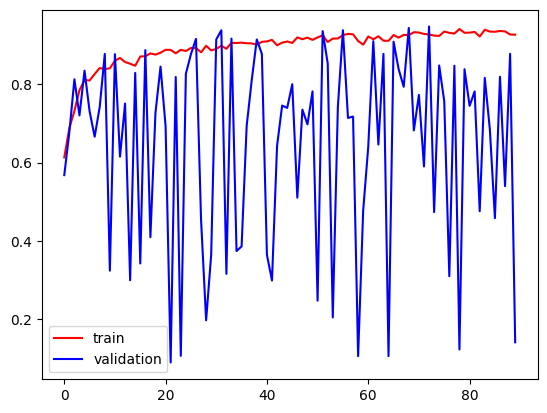

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],color='red',label='train')
plt.plot(history.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

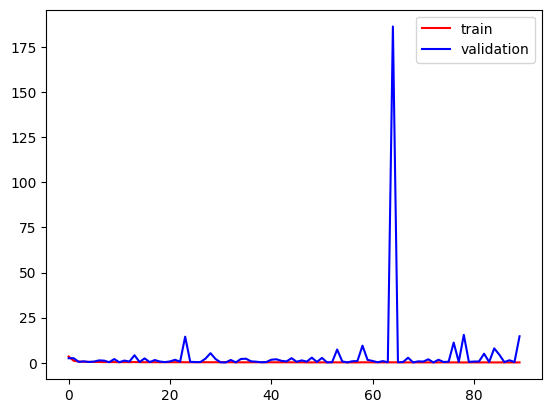

In [ ]:
plt.plot(history.history['loss'],color='red',label='train')
plt.plot(history.history['val_loss'],color='blue',label='validation')
plt.legend()
plt.show()

### Ways to reduce overfitting
- Add more data
- Dropout
- Reduce complexity

In [ ]:
import cv2

In [ ]:
test_img = cv2.imread('viral2.jpg')

<function matplotlib.pyplot.show(close=None, block=None)>

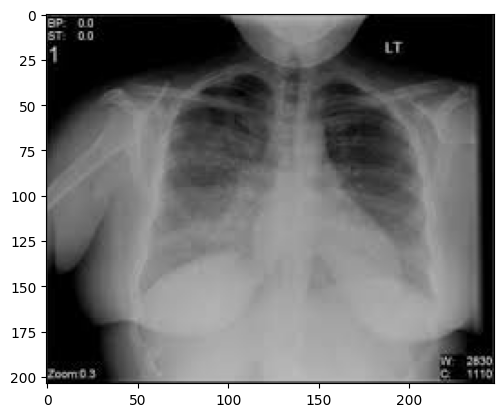

In [ ]:
# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show

In [ ]:
test_img.shape

(204, 247, 3)

In [ ]:
test_img = cv2.resize(test_img,(256,256))

In [ ]:
test_input = test_img.reshape((1,256,256,3))


In [ ]:
test_input.shape

(1, 256, 256, 3)

In [ ]:
print(history.model.input_shape)

(None, 256, 256, 3)


In [ ]:
test_input = tf.cast(test_input, tf.float32) / 255.0
input_prediction = history.model.predict(test_input)
print(input_prediction)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
[[1.0000000e+00 1.6457548e-12 2.8632625e-08]]


In [ ]:
input_pred_label = np.argmax(input_prediction)
print(input_pred_label)
if input_pred_label == 0:
  print('COVID')
elif input_pred_label == 1:
  print('NORMAL')
else:
  print('PNEUMONIA')

0
COVID


# Using Pretrained Models - Resnet50- CNN Only)

# Import Required Libraries

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam


# Load Pre-trained ResNet50 (without top layer)

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze Base Layers (initially)

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

# Add Custom Classification Head

# Option1


In [ ]:
#num_classes = 2  # with_mask and without_mask
#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#predictions = Dense(num_classes, activation='softmax')(x)
#model = Model(inputs=base_model.input, outputs=predictions)

# Option2

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(3,activation='softmax')) # Use 'sigmoid' for binary classification



In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

#train_generator.reset()
#
# validation_generator.reset()

batch_size = 32
train_datagen = ImageDataGenerator(
        rescale=1./255,              # Normalize pixel values
        rotation_range=30,           # Random rotation
        width_shift_range=0.1,       # Horizontal shift
        height_shift_range=0.1,      # Vertical shift
        shear_range=0.2,             # Shear transformation
        zoom_range=0.2,              # Zoom
        horizontal_flip=True,        # Flip horizontally
        fill_mode='nearest'          # Fill strategy for empty pixels
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'Covid19-dataset/train',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')  # Use 'sparse' for integer labels, 'categorical' for one-hot encoded labels
# If you have multiple classes, use 'categorical' or 'sparse' based on your label format

validation_generator = test_datagen.flow_from_directory(
        'Covid19-dataset/test',
        target_size=(256, 256),
        batch_size=batch_size,
        class_mode='categorical')  # Use 'sparse' for integer labels, 'categorical' for one-hot encoded labels

Found 5395 images belonging to 3 classes.
Found 1354 images belonging to 3 classes.


# Compile the Model

In [ ]:

model.compile(optimizer=Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=['accuracy','binary_accuracy','precision','recall','AUC'])

# Overfitting Detected: Suggestions to Fix It


## Suggestions to Reduce Overfitting
### 1. Use Dropout
- Add Dropout layers after dense layers to prevent over-reliance on specific neurons.

**` from tensorflow.keras.layers import Dropout `**

**` x = Dense(1024, activation='relu')(x) `**
**` vvx = Dropout(0.5)(x)  # 50% dropout## `**

### 2. Data Augmentation

- Enable augmentation to improve generalization using ImageDataGenerator.

**` from tensorflow.keras.preprocessing.image import ImageDataGenerator `**

**` train_datagen = ImageDataGenerator( `**
**`     rescale=1./255, `**
**`     rotation_range=20, `**
**`     zoom_range=0.2, `**
**`     width_shift_range=0.2, `**
**`     height_shift_range=0.2, `**
**`     horizontal_flip=True, `**
**`     fill_mode='nearest' `**
**` ) `**

### 3. Add Regularization
- Add L2 (ridge) regularization to dense layers.

**` from tensorflow.keras.regularizers import l2 `**

**` x = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(x) `**

### 4. Fine-tune the Base Model

- Unfreeze the top few layers of your pre-trained ResNet model to allow fine-tuning.

**` for layer in base_model.layers[-30:]: `**
    **` layer.trainable = True `**

## 5. Use EarlyStopping
- Stop training when validation loss stops improving to avoid overfitting.

**` from tensorflow.keras.callbacks import EarlyStopping `**

**` early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) `**
**` model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stop]) `**

## 6. Lower the Learning Rate for Fine-tuning 
- When fine-tuning the model, use a small learning rate for better convergence.

**` from tensorflow.keras.optimizers import Adam `**

**` model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy']) `**

In [ ]:
from keras.callbacks import EarlyStopping
callback1 = EarlyStopping(
    monitor="val_loss",
    min_delta=0.00001,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True)

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint1 = ModelCheckpoint(
    filepath='best_model_base.h5',           # where to save the model
    monitor='val_loss',                 # metric to monitor
    save_best_only=True,               # only save when val_loss improves
    save_weights_only=False,           # set True to save weights only
    mode='min',                        # 'min' for val_loss, 'max' for accuracy
    verbose=1                          # logs when model is saved
)

# Train the Top Layers

In [ ]:
history1 = model.fit(train_generator,validation_data=validation_generator,	epochs=20,callbacks=[checkpoint1,callback1])

Epoch 1/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.7475 - accuracy: 0.5870 - binary_accuracy: 0.7333 - loss: 1.0691 - precision: 0.6009 - recall: 0.5749
Epoch 1: val_loss improved from None to 0.47021, saving model to best_model_base.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - AUC: 0.7903 - accuracy: 0.6358 - binary_accuracy: 0.7587 - loss: 0.6907 - precision: 0.6417 - recall: 0.6248 - val_AUC: 0.8492 - val_accuracy: 0.7230 - val_binary_accuracy: 0.8181 - val_loss: 0.4702 - val_precision: 0.7393 - val_recall: 0.7016
Epoch 2/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8789 - accuracy: 0.7233 - binary_accuracy: 0.8163 - loss: 0.4182 - precision: 0.7260 - recall: 0.7211
Epoch 2: val_loss improved from 0.47021 to 0.43185, saving model to best_model_base.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - AUC: 0.8827 - accuracy: 0.7273 - binary_accuracy: 0.8192 - loss: 0.4111 - precision: 0.7317 - recall: 0.7227 - val_AUC: 0.8783 - val_accuracy: 0.7511 - val_binary_accuracy: 0.8343 - val_loss: 0.4318 - val_precision: 0.7520 - val_recall: 0.7504
Epoch 3/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8893 - accuracy: 0.7333 - binary_accuracy: 0.8237 - loss: 0.4012 - precision: 0.7414 - recall: 0.7235
Epoch 3: val_loss improved from 0.43185 to 0.40421, saving model to best_model_base.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - AUC: 0.8946 - accuracy: 0.7448 - binary_accuracy: 0.8314 - loss: 0.3932 - precision: 0.7540 - recall: 0.7336 - val_AUC: 0.9024 - val_accuracy: 0.6957 - val_binary_accuracy: 0.7974 - val_loss: 0.4042 - val_precision: 0.6965 - val_recall: 0.6950
Epoch 4/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.8903 - accuracy: 0.7385 - binary_accuracy: 0.8257 - loss: 0.3920 - precision: 0.7455 - recall: 0.7242
Epoch 4: val_loss improved from 0.40421 to 0.28816, saving model to best_model_base.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - AUC: 0.9002 - accuracy: 0.7477 - binary_accuracy: 0.8330 - loss: 0.3729 - precision: 0.7565 - recall: 0.7359 - val_AUC: 0.9459 - val_accuracy: 0.7917 - val_binary_accuracy: 0.8631 - val_loss: 0.2882 - val_precision: 0.7969 - val_recall: 0.7910
Epoch 5/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9146 - accuracy: 0.7651 - binary_accuracy: 0.8452 - loss: 0.3452 - precision: 0.7747 - recall: 0.7552
Epoch 5: val_loss did not improve from 0.28816
169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - AUC: 0.9153 - accuracy: 0.7648 - binary_accuracy: 0.8449 - loss: 0.3444 - precision: 0.7737 - recall: 0.7559 - val_AUC: 0.8757 - val_accuracy: 0.6743 - val_binary_accuracy: 0.7834 - val_loss: 0.4075 - val_precision: 0.6806 - val_recall: 0.6595
Epoch 6/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9240 - accuracy: 0.7872 - binary_accuracy: 0.8556 - loss: 0.3301 - precision: 0.7899 - recall: 0.7722
Epoch 6: val_loss improved from 0.28816 to 0.26079, s

169/169 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - AUC: 0.9340 - accuracy: 0.7994 - binary_accuracy: 0.8656 - loss: 0.3067 - precision: 0.8039 - recall: 0.7892 - val_AUC: 0.9552 - val_accuracy: 0.8287 - val_binary_accuracy: 0.8855 - val_loss: 0.2608 - val_precision: 0.8315 - val_recall: 0.8235
Epoch 7/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9242 - accuracy: 0.7895 - binary_accuracy: 0.8605 - loss: 0.3258 - precision: 0.7949 - recall: 0.7836
Epoch 7: val_loss improved from 0.26079 to 0.23371, saving model to best_model_base.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - AUC: 0.9273 - accuracy: 0.7900 - binary_accuracy: 0.8609 - loss: 0.3200 - precision: 0.7960 - recall: 0.7833 - val_AUC: 0.9616 - val_accuracy: 0.8634 - val_binary_accuracy: 0.9099 - val_loss: 0.2337 - val_precision: 0.8665 - val_recall: 0.8626
Epoch 8/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9413 - accuracy: 0.8066 - binary_accuracy: 0.8730 - loss: 0.2883 - precision: 0.8133 - recall: 0.8035
Epoch 8: val_loss did not improve from 0.23371
169/169 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - AUC: 0.9333 - accuracy: 0.7948 - binary_accuracy: 0.8642 - loss: 0.3045 - precision: 0.8011 - recall: 0.7883 - val_AUC: 0.9543 - val_accuracy: 0.8323 - val_binary_accuracy: 0.8892 - val_loss: 0.2711 - val_precision: 0.8368 - val_recall: 0.8294
Epoch 9/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9332 - accuracy: 0.7934 - binary_accuracy: 0.8635 - loss: 0.3044 - precision: 0.7990 - recall: 0.7891
Epoch 9: val_loss did not improve from 0.23371
169/16

169/169 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - AUC: 0.9489 - accuracy: 0.8258 - binary_accuracy: 0.8843 - loss: 0.2626 - precision: 0.8298 - recall: 0.8213 - val_AUC: 0.9720 - val_accuracy: 0.8730 - val_binary_accuracy: 0.9163 - val_loss: 0.2101 - val_precision: 0.8756 - val_recall: 0.8730
Epoch 13/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9386 - accuracy: 0.8146 - binary_accuracy: 0.8757 - loss: 0.2878 - precision: 0.8166 - recall: 0.8088
Epoch 13: val_loss did not improve from 0.21015
169/169 ━━━━━━━━━━━━━━━━━━━━ 264s 2s/step - AUC: 0.9358 - accuracy: 0.8091 - binary_accuracy: 0.8728 - loss: 0.2960 - precision: 0.8123 - recall: 0.8044 - val_AUC: 0.9419 - val_accuracy: 0.8117 - val_binary_accuracy: 0.8762 - val_loss: 0.2823 - val_precision: 0.8164 - val_recall: 0.8109
Epoch 14/20
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - AUC: 0.9376 - accuracy: 0.8110 - binary_accuracy: 0.8734 - loss: 0.2919 - precision: 0.8132 - recall: 0.8050
Epoch 14: val_loss did not improve from 0.21015
16

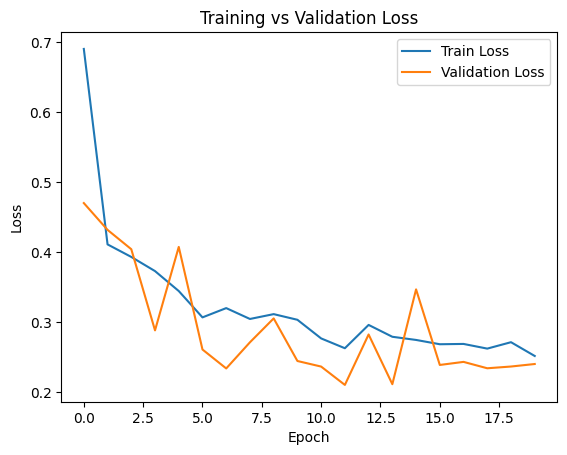

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

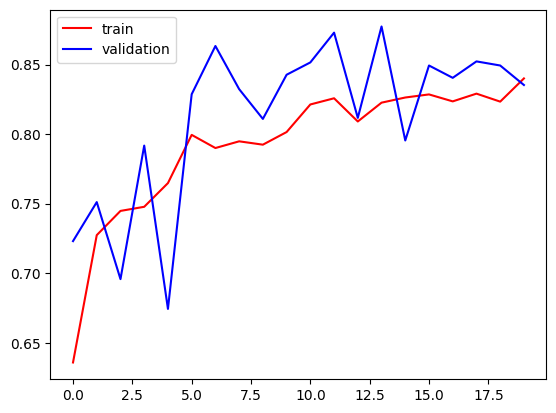

In [ ]:
import matplotlib.pyplot as plt
history1.history1 = history1.history
plt.plot(history1.history['accuracy'],color='red',label='train')
plt.plot(history1.history['val_accuracy'],color='blue',label='validation')
plt.legend()
plt.show()

(None, 256, 256, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[9.7972417e-01 8.8617025e-04 1.9389568e-02]]
0
COVID


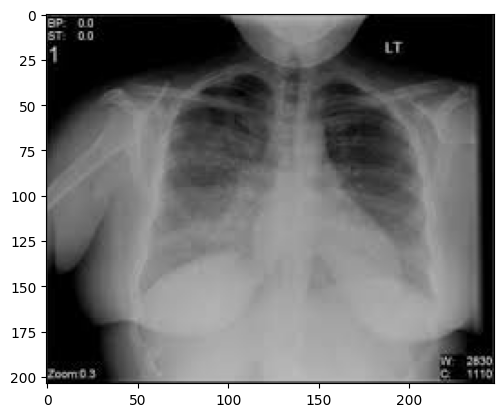

In [ ]:
import cv2
test_img = cv2.imread('viral2.jpg')
# Convert BGR to RGB for correct display
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.show
test_img.shape
test_img = cv2.resize(test_img,(256,256))
test_input = test_img.reshape((1,256,256,3))

test_input.shape
print(history1.model.input_shape)
test_input = tf.cast(test_input, tf.float32) / 255.0
input_prediction = history1.model.predict(test_input)
print(input_prediction)

input_pred_label = np.argmax(input_prediction)
print(input_pred_label)
if input_pred_label == 0:
  print('COVID')
elif input_pred_label == 1:
  print('NORMAL')
else:
  print('PNEUMONIA')

# Fine-Tune Some Deeper Layers

In [ ]:
for layer in base_model.layers[-30:]:  # Unfreeze last 30 layers
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5),loss='categorical_crossentropy',metrics=['accuracy'])
model.fit(train_generator, validation_data=validation_generator, epochs=5)
# Save the model
model.save('base_tunes.h5')   

Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.7531 - loss: 0.9211 - val_accuracy: 0.3907 - val_loss: 1.4996
Epoch 2/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8500 - loss: 0.3842 - val_accuracy: 0.7290 - val_loss: 0.6063
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8601 - loss: 0.3472 - val_accuracy: 0.9099 - val_loss: 0.2672
Epoch 4/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.8612 - loss: 0.3406 - val_accuracy: 0.8966 - val_loss: 0.2620
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.8675 - loss: 0.3211 - val_accuracy: 0.9210 - val_loss: 0.2499


In [ ]:
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array

# Load the trained Keras model
model = load_model('best_model.h5')

# Class labels (adjust to your dataset)
species = ['COVID', 'No COVID', 'PNEMONIA']

# App title
st.title("🦠 Covid Classification")

# File uploader for image
uploaded_file = st.file_uploader("Upload an image of a Chest Scan", type=["jpg", "jpeg", "png"])

if uploaded_file is not None:
    # Open image
    image = Image.open(uploaded_file).convert('RGB')
    st.image(image, caption='Uploaded Image', use_column_width=True)

    # Preprocess image (adjust size to model's expected input)
    img_size = (256, 256)  # change to the size your model was trained on
    image = image.resize(img_size)
    img_array = img_to_array(image) / 255.0  # normalize if trained that way
    img_array = np.expand_dims(img_array, axis=0)  # add batch dimension

    # Predict button
    if st.button("Predict"):
        prediction = model.predict(img_array)
        pred_class = np.argmax(prediction, axis=1)[0]
        st.success(f"Predicted Classification: **{species[pred_class]}**")


2025-08-13 19:11:43.900 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.131 
  command:

    streamlit run c:\DataScience\tensor_python310\Lib\site-packages\ipykernel_launcher.py [ARGUMENTS]
2025-08-13 19:11:44.132 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.133 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.134 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.136 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.137 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-13 19:11:44.139 Thread 'MainThre